In [48]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import seaborn as sns
from sklearn.model_selection import KFold
from IPython.display import HTML, display
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

usarrests = pd.read_csv('data/USArrests.csv', index_col=0)

### This data set contains statistics, in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas.


In [49]:
usarrests.head()
# usarrests.colum

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [50]:
from sklearn.preprocessing import scale

usarr_scaled = pd.DataFrame(scale(usarrests), 
                            columns=usarrests.columns)

In [51]:
usarr_scaled.head()

,Murder,Assault,UrbanPop,Rape
0,1.255179,0.790787,-0.526195,-0.003451
1,0.513019,1.118060,-1.224067,2.509424
2,0.072361,1.493817,1.009122,1.053466
3,0.234708,0.233212,-1.084492,-0.186794
4,0.281093,1.275635,1.776781,2.088814


-비지도 변환은 데이터를 새롭게 표현하여 사람이나 다른 머신러닝 알고리즘이 원래 데이터보다 쉽게 해석할 수 있도록 만드는 알고리즘<br>
특성이 많은 고차원 데이터를 특성의 수를 줄이면서 꼭 필요한 특징을 포함한 데이터로 표현하는 방법인 차원 축소<br>
차원 축소의 대표적인 예는 시각화를 위해 데이터셋을 2차원으로 변경하는 경우, 데이터를 압축하거나, 추가적인 처리를 위해 정보가 더 잘 드러나는 표현을 찾이 위해서 입니다<br><br>

-군집 알고리즘은 데이터를 비슷한 것끼리 그룹으로 묶는 것<br>
소셜 미디어 사이트에 업로드된 사진을 분류하려면 같은 사람이 찍힌 사진을 같은 그룹으로 묶을수있다<br>

## PCA (Principal component analysis)

In [67]:
pca = PCA(n_components=4)
pca.fit(usarr_scaled)

X_pca = pca.transform(usarr_scaled)
print("원본 데이터 형태: {}".format(str(usarr_scaled.shape)))
print("축소된 데이터 형태: {}".format(str(X_pca.shape)))

원본 데이터 형태: (50, 4)
축소된 데이터 형태: (50, 4)


- 주성분 분석(PCA)은 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전시키는 기술<br>
성분1 이라고 쓰여 있는 분산이 가장 큰 방향을 찾는다. 이 방향(또는 벡터)이 데이터에서 가장 많은 정보를 담고 있는 방향<br>
다른말로, 특성들의 상관관계가 가장 큰 방향<br>
다음으로 첫 번째 방향과 직각인 방향 중에서 가장 많은 정보를 담은 방향을 찾습니다. 2차원에서는 가능한 직각 방향이 하나뿐이지만
고차원에서는 많은 직각 방향이 있을수 있다.

Text(0,0.5,'두 번째 주성분')

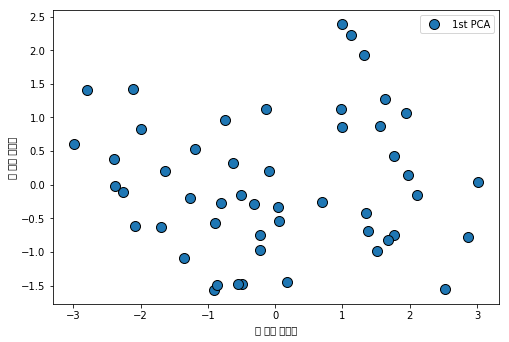

In [68]:
import mglearn

plt.figure(figsize=(8,8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1])
plt.legend(["1st PCA", "2nd PCA"], loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("첫 번째 주성분")
plt.ylabel("두 번째 주성분")

-The first two principal components for the USArrests data. <br>
***
이 산점도는 첫 번째 주성분과 두 번째 주성분을 사용하여 만듬<br>
PCA 단점은 그래프의 두 축을 해석하기가 쉽지않다는 점. 주성분은 원본 데이터에 있는 어떤 방향에 대응하는 여러 특성이 조합된 형태



In [69]:
print("PCA 주성분 형태: {}".format(pca.components_.shape))

PCA 주성분 형태: (4, 4)


In [70]:
# components_ 의 각 행은 주성분 하나씩을 나타내며 중요도에 따라 정렬
print("PCA 주성분:\n{}".format(pca.components_))


PCA 주성분:
[[ 0.53589947  0.58318363  0.27819087  0.54343209]
 [ 0.41818087  0.1879856  -0.87280619 -0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [ 0.6492278  -0.74340748  0.13387773  0.08902432]]


### scree plot와 Cumulative plot 그리고 각 PC의 갯수별 variance

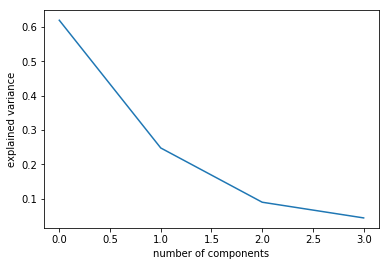

In [71]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

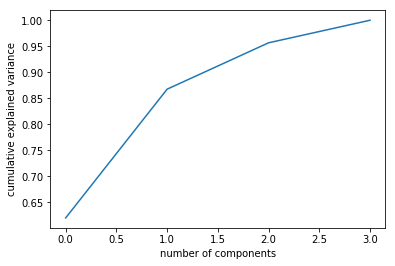

In [72]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

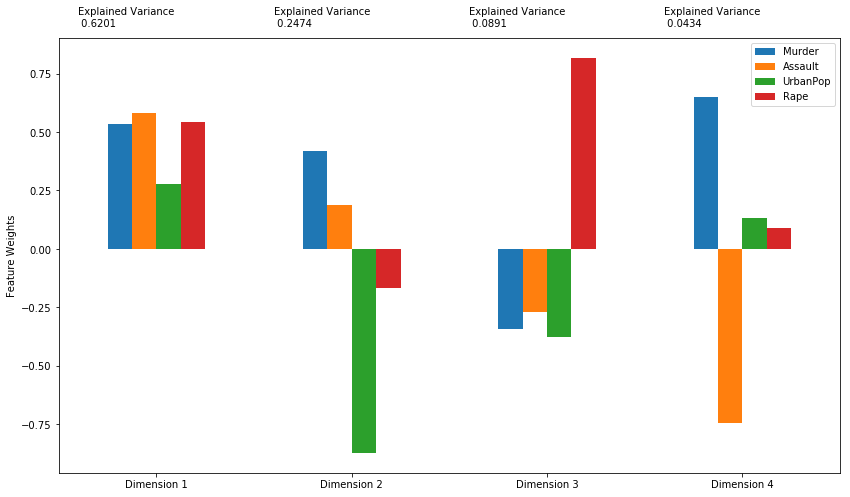

In [73]:
def pca_results(data, pca):
    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()) 
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1) 
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance']) 
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar')
    ax.set_ylabel("Feature Weights") 
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios# 
    for i, ev in enumerate(pca.explained_variance_ratio_): 
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

pca_results = pca_results(usarr_scaled, pca)

In [74]:
pca_results.cumsum()


,Explained Variance,Murder,Assault,UrbanPop,Rape
Dimension 1,0.6201,0.5359,0.5832,0.2782,0.5434
Dimension 2,0.8675,0.9541,0.7712,-0.5946,0.3761
Dimension 3,0.9566,0.6129,0.5031,-0.9726,1.1939
Dimension 4,1.0000,1.2621,-0.2403,-0.8387,1.2829


- 첫번째 주성분은 Murder, Assault, Rape의 비율이 높은것으로 보아 범죄가 발생하는 도시를 기록한 것으로 보이며,<br>
두번째 주성분은 도시인구 를 담고 있는 것으로 보입니다.<br>
PCA 변환은 데이터를 회전시키고 분산이 작은 주성분을 덜어내는 것<br>
첫번째 주성분만으로도 분산의 62%를 설명할수있습니다. 주성분을 특성수만큼 사용하면 변환후에 어떤 정보도 잃지 않게 되므로<br>
데이터를 완벽하게 재구성할 수 있습니다.

### 4차원일때 Kmeans를 돌려서 군집화해보기. 특정 k를 선택한 이유를 설명하고 실제 k로 나눈 후에 각 클러스터별 특성 파악

## K-means

In [60]:
from mpl_toolkits.mplot3d import Axes3D

X = usarr_scaled

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
# print("클러스터 레이블:\n{}".format(kmeans.labels_))
y_kmeans = kmeans.predict(X)
print(y_kmeans)

# centers = kmeans.cluster_centers_
# centers

[1 1 1 0 1 1 2 2 1 1 2 0 1 2 0 2 0 1 0 1 2 1 0 1 1 0 0 1 0 2 1 1 1 0 2 2 2
 2 2 1 0 1 1 2 0 2 2 0 0 2]


- 군집은 데이터셋을 클러스터 라는 그룹으로 나누는 작업, 한 클러스터 안의 데이터 포인트끼리는 매우 비슷하고<br>
다른 클러스터의 데이터 포인트와는 구분되도록 데이터를 나누는 것이 목표<br><br>

- K-평균 알고리즘은 데이터의 어떤 영역을 대표하는 클러스터 중심을 찾는다. 알고리즘은 두 단계를 반복
1. 데이터 포인트를 가장 가까운 클러스터 중심에 할당
2. 클러스터에 할당된 데이터 포인트의 평균으로 클러스터 중심을 다시 지정
클러스터에 할당되는 데이터 포인트에 변화가 없을때 알고리즘이 종료


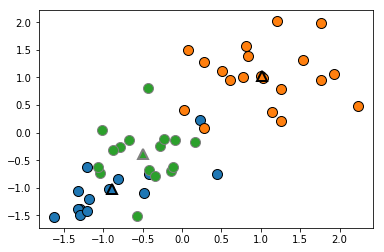

In [61]:
import mglearn

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers='^', markeredgewidth=2)

- k-평균 알고리즘으로 찾은 세 개의 클러스터 중심과 클러스터 할당

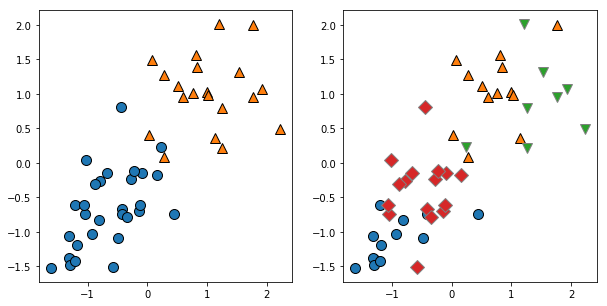

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 두 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[0])

# 네 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[1])

- k-평균 알고리즘으로 클러스터를 두 개 사용했을 때와 네 개 사용했을때 의 클러스터 할당

- k-평균은 클러스터 중심으로 각 데이터 포인트를 표현. 이를 각 데이터 포인트가 클러스터 중심, 즉 하나의 성분<br>
k-평균을 이렇게 각 포인트가 하나의 성분으로 분해되는 관점으로 보는 것을 벡터 양자화라고 한다


### 2차원으로 축소한 후 축소된 2차원의 Score Vector에 다시 kmeans를 돌려 군집하고 해석하기

In [63]:
data = usarr_scaled
pca = PCA(n_components=2).fit(data)
reduced_data = pca.transform(data)
# pca_samples = pca.transform(data)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

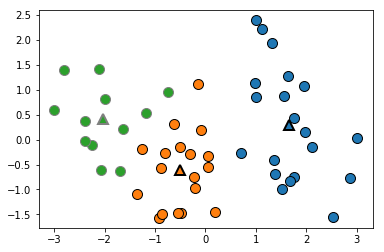

In [64]:
X = reduced_data
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], kmeans.labels_, markers='o')
mglearn.discrete_scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], [0, 1, 2], markers='^', markeredgewidth=2)

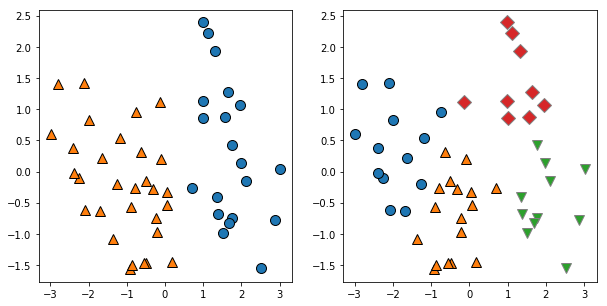

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 두 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[0])

# 네 개의 클러스터 중심을 사용합니다
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
assignments = kmeans.labels_

mglearn.discrete_scatter(X.values[:, 0], X.values[:, 1], assignments, ax=axes[1])

## 병합 군집 (agglomerative clustering)

- 병합 군집 알고리즘은 시작할 때 각 포인트를 하나의 클러스터로 지정하고, 그 다음 어떤 종료조건을 만족할 때까지 가장 비슷한<br>
두 클러스터를 합쳐나간다. 지정된 개수의 클러스터가 남을 때까지 비슷한 클러스터를 합친다.<br>

- 병합 군집은 계층적 군집(Hierarchical clustering)을 만든다. 군집이 반복하여 진행되면 모든 포인트는 하나의 포인트를 가진<br>
클러스터에서 시작하여 클러스터까지 이동하게 된다. 각 중간 단계는 데이터에 대한 (각기 다른 개수의) 클러스터를 생성<br>

- 계층 군집을 시각화하는 도구인 덴드로그램은 다차원 데이터셋을 처리

Text(0,0.5,'클러스터 거리')

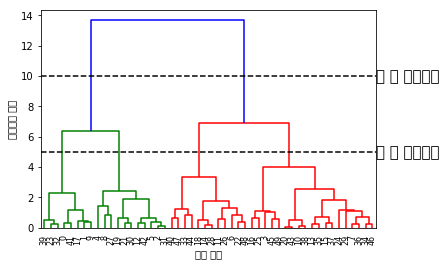

In [66]:
from scipy.cluster.hierarchy import dendrogram, ward

# X, y = make_blobs(random_state=0, n_samples=12)
linkage_array = ward(X)
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [10, 10], '--', c='k')
ax.plot(bounds, [5,5], '--', c='k')

ax.text(bounds[1], 10, '두 개 클러스터', va='center', fontdict={'size':15})
ax.text(bounds[1], 5, '네 개 클러스터', va='center', fontdict={'size':15})
plt.xlabel("샘플 번호")
plt.ylabel("클러스터 거리")


- 덴드로그램에서 데이터 포인트는 맨 아래 나타난다. 각각이 하나의 클러스터인 이 포인트들을 잎으로 하는 트리가 만들어지며<br>
새로운 부모 노드는 두 클러스터가 합쳐질때 추가

## DBSCAN (Density-based spatial clustering of applications with noise)

- 특성 공간에서 가까이 있는 데이터가 많아 붐비는 지역의 포인트를 찾는다. 이런 지역을 특성 공간의 밀집지역이라 한다<br>
DBSCAN의 아이디어는 데이터의 밀집 지역이 한 클러스터를 구성하며 비교적 비어있는 지역을 경계로 다른 클러스터와 구분된다는 것<br>

밀집 지역에 있는 포인트를 핵심 샘플이라고 하며 DBSCAN 에는 두 개의 매개변수 min_samples, eps가 있다<br>
한 데이터 포인트에서 eps 거리 안에 데이터가 min_samples 개수만큼 들어 있으면 이 데이터 포인트를 핵심 샘플로 분류<br>
eps 보다 가까운 핵심 샘플은 DBSCAN 에 의해 동일한 클러스터로 합쳐진다